In [1]:
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path

# Import from project modules
import utils
from data_preparation import get_testing_loader
from models.lstnet import LSTNET

# LSTNET Training Analysis Notebook

This notebook provides comprehensive analysis and visualization tools for LSTNET model training.

## Key Features:
- **Latent Loss Visualization**: All plotting functions now include latent space discriminator and encoder-generator losses
- **Unified Helper Functions**: Refactored to use consistent helper functions (`get_loss_data`, `plot_discriminator_losses`, `plot_enc_gen_losses`, `plot_cycle_consistency_losses`)
- **Comprehensive Plotting**: New `plot_all_losses_comprehensive()` function shows all loss components in a single view

## Available Plotting Functions:
1. `plot_component_losses()` - Plot discriminator, encoder-generator, and cycle consistency losses
2. `plot_total_losses()` - Plot total training and validation losses
3. `compare_total_losses()` - Compare total losses between two models
4. `compare_component_losses()` - Compare component losses between two models
5. `plot_all_losses_comprehensive()` - **NEW**: Comprehensive view of all losses including latent losses

## Loss Components Tracked:
- **Discriminator Loss**: First Domain, Second Domain, Latent Space
- **Encoder-Generator Loss**: First Domain, Second Domain, Latent Space
- **Cycle Consistency Loss**: First Cycle, Second Cycle, First Full Cycle, Second Full Cycle

In [5]:
def find_misclassified_images(clf_model, data_loader, device='cuda'):
    """
    Find images that were classified incorrectly.
    
    Args:
        clf_model: Trained classifier model
        data_loader: DataLoader containing images and labels
        device (str): Device to run inference on
        
    Returns:
        tuple: (misclassified_images, true_labels, predicted_labels, indices)
    """
    clf_model.to(device)
    clf_model.eval()
    
    misclassified_images = []
    true_labels = []
    predicted_labels = []
    indices = []
    
    current_idx = 0
    
    with torch.no_grad():
        for batch_imgs, batch_labels in data_loader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)
            
            # Get predictions
            outputs = clf_model(batch_imgs)
            preds = outputs.argmax(dim=1)
            
            # Find misclassified samples
            misclassified_mask = preds != batch_labels
            
            if misclassified_mask.any():
                # Get misclassified images
                miscls_imgs = batch_imgs[misclassified_mask].cpu()
                miscls_true = batch_labels[misclassified_mask].cpu()
                miscls_pred = preds[misclassified_mask].cpu()
                
                # Store results
                misclassified_images.append(miscls_imgs)
                true_labels.append(miscls_true)
                predicted_labels.append(miscls_pred)
                
                # Store indices
                batch_indices = torch.where(misclassified_mask)[0] + current_idx
                indices.append(batch_indices.cpu())
            
            current_idx += len(batch_imgs)
    
    # Concatenate all batches
    if misclassified_images:
        misclassified_images = torch.cat(misclassified_images, dim=0)
        true_labels = torch.cat(true_labels, dim=0)
        predicted_labels = torch.cat(predicted_labels, dim=0)
        indices = torch.cat(indices, dim=0)
    else:
        print("No misclassified images found!")
        return None, None, None, None
    
    print(f"Found {len(misclassified_images)} misclassified images out of {current_idx} total")
    print(f"Accuracy: {100 * (1 - len(misclassified_images) / current_idx):.2f}%")
    
    return misclassified_images, true_labels, predicted_labels, indices

In [7]:
def analyze_classifier_misclassifications(clf_model, data_loader, num_samples=20, 
                                         figsize=(20, 12), save_path=None, device='cuda'):
    """
    Analyze and visualize misclassifications for a standalone classifier.
    Displays original images with true and predicted labels.
    
    Args:
        clf_model: Trained classifier model
        data_loader: DataLoader containing images and labels
        num_samples (int): Maximum number of misclassified samples to display
        figsize (tuple): Figure size for the plot
        save_path (str, optional): If provided, saves the plot to this path
        device (str): Device to run inference on
        
    Returns:
        tuple: (misclassified_images, true_labels, predicted_labels, indices)
    """
    # Find misclassified images
    miscls_imgs, true_lbls, pred_lbls, indices = find_misclassified_images(
        clf_model, data_loader, device=device
    )
    
    if miscls_imgs is None:
        return None, None, None, None
    
    # Limit to num_samples
    num_to_show = min(num_samples, len(miscls_imgs))
    
    # Calculate grid dimensions
    cols = 5
    rows = (num_to_show + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if num_to_show > 1 else [axes]
    
    for i in range(num_to_show):
        ax = axes[i]
        img = miscls_imgs[i].squeeze().cpu().numpy()
        
        # Handle different image formats (grayscale vs RGB)
        if img.ndim == 3 and img.shape[0] in [1, 3]:
            if img.shape[0] == 1:
                img = img.squeeze(0)
            else:
                img = np.transpose(img, (1, 2, 0))
        
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
        ax.set_title(f'True: {true_lbls[i].item()}\\nPredicted: {pred_lbls[i].item()}', 
                     fontsize=11, fontweight='bold', color='red')
        ax.axis('off')
    
    # Hide unused subplots
    for j in range(num_to_show, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(f'Classifier Misclassifications (showing {num_to_show} of {len(miscls_imgs)})', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
        plt.close()
    else:
        plt.show()
    
    return miscls_imgs, true_lbls, pred_lbls, indices

## Example Usage

In [22]:
folder_name = 'output_base_uda_100_freq_3'

In [24]:
# Load losses from output folder
loss_log_path = f'{folder_name}/loss_logs.json'
losses = load_losses(loss_log_path)

# Plot component losses for training (display)
plot_component_losses(losses, split='train', save_path=f'{folder_name}/analysis/train_component_losses.png')

Plot saved to output_base_uda_100_freq_3/analysis/train_component_losses.png


In [34]:
# Plot total losses (train vs val) - display
plot_total_losses(losses, save_path=f'{folder_name}/analysis/train_component_losses.png')

Plot saved to output_base_uda_100_freq_3/analysis/train_component_losses.png


### Comprehensive Loss Visualization (Including Latent Losses)

In [ ]:
# Plot all losses comprehensively for a single model
plot_all_losses_comprehensive(losses, split='train', save_path=f'{folder_name}/analysis/comprehensive_losses.png')

In [57]:
folder1 = 'output_base_uda_100'
folder2 = 'output_base_uda_100_freq_3'
output_folder = 'analysis'

In [58]:
losses1 = load_losses(f'{folder1}/loss_logs.json')
losses2 = load_losses(f'{folder2}/loss_logs.json')

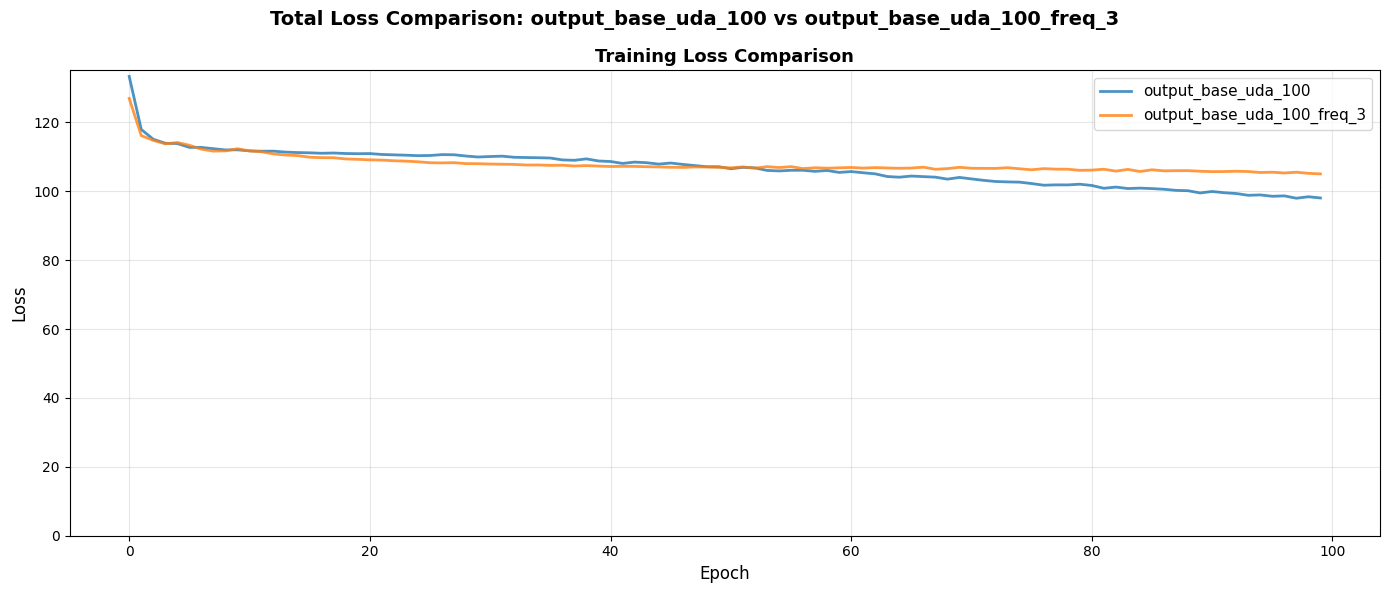

In [59]:
compare_total_losses(losses1, losses2, folder1, folder2)

In [60]:
compare_total_losses(losses1, losses2, folder1, folder2, save_path=f'{folder1}/{output_folder}/comparison_{folder1}_vs{folder2}')
compare_total_losses(losses1, losses2, folder1, folder2, save_path=f'{folder2}/{output_folder}/comparison_{folder1}_vs{folder2}')

Plot saved to output_base_uda_100/analysis/comparison_output_base_uda_100_vsoutput_base_uda_100_freq_3
Plot saved to output_base_uda_100_freq_3/analysis/comparison_output_base_uda_100_vsoutput_base_uda_100_freq_3


C:\Users\skotj\AppData\Local\Temp\ipykernel_49828\320684231.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9)
C:\Users\skotj\AppData\Local\Temp\ipykernel_49828\320684231.py:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9)
C:\Users\skotj\AppData\Local\Temp\ipykernel_49828\320684231.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9)
C:\Users\skotj\AppData\Local\Temp\ipykernel_49828\320684231.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is ca

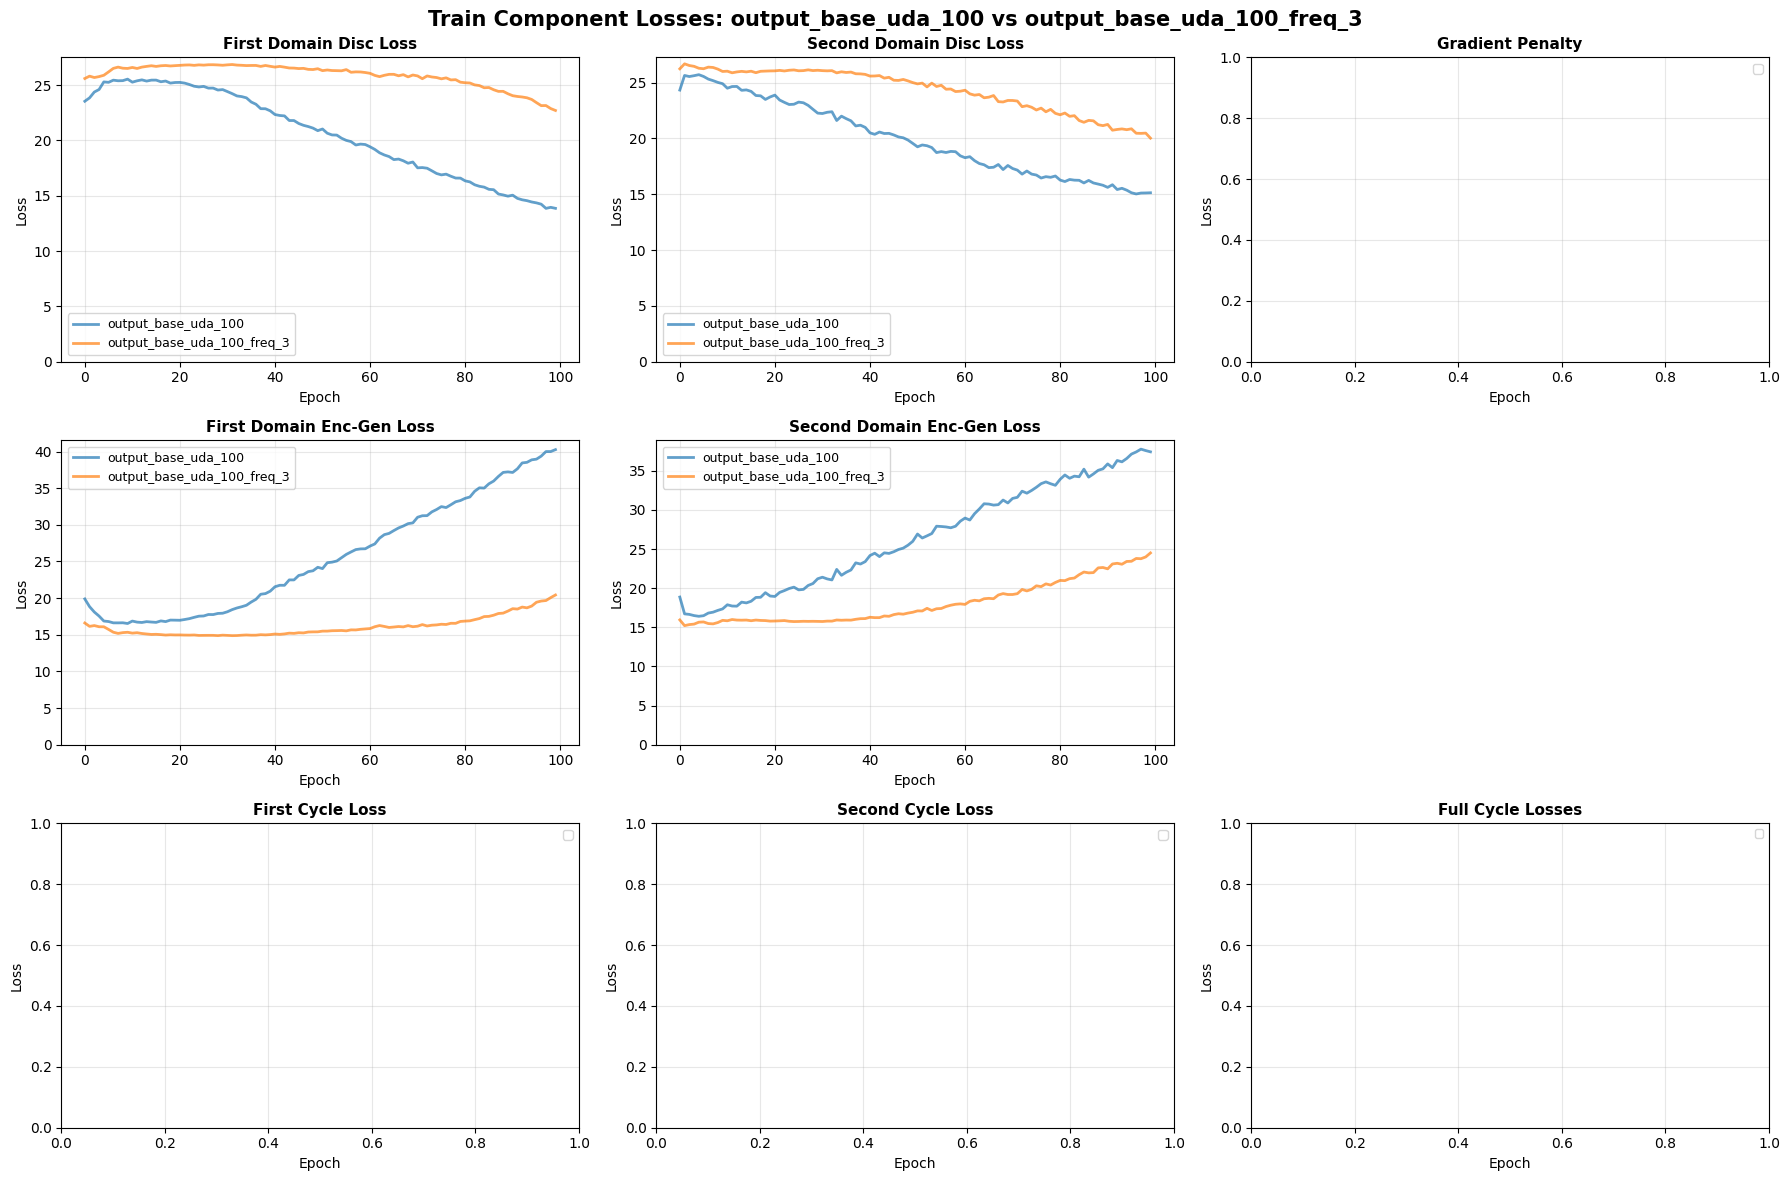

In [61]:
compare_component_losses(losses1, losses2, folder1, folder2)

### Find Misclassified Images

In [ ]:
# Example: Load translated data and classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the translated data
translated_data_path = 'output_base_uda_100/MNIST_translated_data.pt'
translated_data = torch.load(translated_data_path, weights_only=False)
data_loader = DataLoader(translated_data, batch_size=64, shuffle=False)

# Load the classifier (adjust path to your classifier)
clf_model_path = 'usps_clf_base/USPS_clf_model.pth'  # Adjust based on your target domain
clf_model = torch.load(clf_model_path, weights_only=False, map_location=device)

print("Models loaded successfully!")

In [ ]:
# Find misclassified images
miscls_imgs, true_lbls, pred_lbls, miscls_indices = find_misclassified_images(
    clf_model, data_loader, device=device
)

In [ ]:
# Visualize misclassified images (display)
visualize_misclassified(miscls_imgs, true_lbls, pred_lbls, num_samples=25)

In [ ]:
# Or save to file instead:
# visualize_misclassified(miscls_imgs, true_lbls, pred_lbls, num_samples=25, 
#                        save_path='results/misclassified_images.png')

In [ ]:
# Analyze misclassification patterns
analyze_misclassification_patterns(true_lbls, pred_lbls)

## Advanced Analysis Examples

### 1. Classifier-Only Misclassification Analysis

Analyze misclassifications for a standalone classifier (without domain adaptation).
Displays: **Original Image** with **True Label** and **Predicted Label**.

In [ ]:
# Example: Analyze classifier misclassifications on original test data
from data_preparation import get_testing_loader

# Load original domain data (e.g., MNIST test set)
orig_loader = get_testing_loader('MNIST', batch_size=64, num_workers=4)

# Load classifier for original domain
clf_mnist = torch.load('mnist_clf_base/MNIST_clf_model.pth', weights_only=False, map_location=device)

# Analyze and visualize misclassifications (display)
results = analyze_classifier_misclassifications(
    clf_model=clf_mnist,
    data_loader=orig_loader,
    num_samples=15,
    device=device
)

In [ ]:
# Or save to file:
# results = analyze_classifier_misclassifications(
#     clf_model=clf_mnist,
#     data_loader=orig_loader,
#     num_samples=20,
#     save_path='results/mnist_classifier_misclassifications.png',
#     device=device
# )

### 2. LSTNET Domain Adaptation Misclassification Analysis

Analyze misclassifications through the full LSTNET pipeline.
Displays: **Original Image** -> **Translated Image** -> **Prediction** for incorrectly classified cases.

In [ ]:
# Example: Analyze LSTNET domain adaptation misclassifications
from data_preparation import get_testing_loader

# Load the LSTNET model
lstnet_model_path = 'output_base_uda_100/lstnet.pth'
lstnet = torch.load(lstnet_model_path, weights_only=False, map_location=device)

# Load original domain test data (e.g., MNIST)
mnist_test_loader = get_testing_loader('MNIST', batch_size=64, num_workers=4)

# Load classifier for target domain (e.g., USPS)
usps_clf = torch.load('usps_clf_base/USPS_clf_model.pth', weights_only=False, map_location=device)

# Analyze and visualize (display)
lstnet_results = analyze_lstnet_misclassifications(
    lstnet_model=lstnet,
    clf_model=usps_clf,
    data_loader=mnist_test_loader,
    domain_name='MNIST',  # Original domain name
    num_samples=15,
    device=device
)

In [ ]:
# Or save to file:
# lstnet_results = analyze_lstnet_misclassifications(
#     lstnet_model=lstnet,
#     clf_model=usps_clf,
#     data_loader=mnist_test_loader,
#     domain_name='MNIST',
#     num_samples=20,
#     save_path='results/lstnet_mnist_to_usps_misclassifications.png',
#     device=device
# )

In [ ]:
# Example: Analyze reverse direction (USPS -> MNIST)
# usps_test_loader = get_testing_loader('USPS', batch_size=64, num_workers=4)
# mnist_clf = torch.load('mnist_clf_base/MNIST_clf_model.pth', weights_only=False, map_location=device)

# lstnet_results_reverse = analyze_lstnet_misclassifications(
#     lstnet_model=lstnet,
#     clf_model=mnist_clf,
#     data_loader=usps_test_loader,
#     domain_name='USPS',
#     num_samples=15,
#     save_path='results/lstnet_usps_to_mnist_misclassifications.png',
#     device=device
# )

### Accessing Results

Both analysis functions return detailed results that you can use for further analysis:

In [ ]:
# For LSTNET analysis, you can access:
if lstnet_results is not None:
    print(f"Number of misclassified: {len(lstnet_results['original_images'])}")
    print(f"Overall accuracy: {lstnet_results['accuracy']:.2f}%")
    
    # Access specific components
    orig_images = lstnet_results['original_images']
    translated_images = lstnet_results['translated_images']
    true_labels = lstnet_results['true_labels']
    predicted_labels = lstnet_results['predicted_labels']
    
    # Analyze specific cases
    analyze_misclassification_patterns(true_labels, predicted_labels)